In [1]:
# Code based on the physics-informed DeepONet implementation of Sifan Wang
# https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.config import config
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
%matplotlib inline

import numpy as onp
from sklearn.mixture import GaussianMixture

In [4]:
# RealNVP block
def RealNVP(layers):
    input_dim = layers[0]
    split = input_dim // 2
    layers[0] = split
    _init, _apply = MLP_branch(layers)
    def init(rng_key):
        params = _init(rng_key)
        return params
    def apply(params, inputs):
        lower = inputs[:split]
        upper = inputs[split:]
        s, t = _apply(params, lower).split(2)
        upper = upper * np.exp(s) + t
        outputs = np.concatenate([lower, upper])
        return outputs
    def invert(params, inputs):
        lower = inputs[:split]
        upper = inputs[split:]
        s,t = _apply(params, lower).split(2)
        upper = (upper - t) * np.exp(-s)
        outputs = np.concatenate([lower, upper])
        return outputs
    def Jacobian(params, inputs):
        lower = inputs[:split]
        upper = inputs[split:]
        s,t = _apply(params, lower).split(2)
        return np.sum(s)
    return init, apply, invert, Jacobian

In [5]:
# Layer to reverse the states
def Reverse(input_dim):
    perm = np.arange(input_dim)[::-1]
    def init(rng_key):
        return ()
    def apply(params, inputs):
        return inputs[perm]
    def invert(params, inputs):
        return inputs[perm]
    def Jacobian(params, inputs):
        return 0.
    return init, apply, invert,Jacobian

In [6]:
# Stack of (RealNVP, Reverse) layers
def Serial(*blocks):
    def init(rng_key):
        params = []
        for (_init, _, _,_) in blocks:
            rng_key, rng_subkey = random.split(rng_key)
            params.append(_init(rng_subkey))
        return params
    def apply(params, inputs):
        for i, (_, _apply, _,_) in enumerate(blocks):
            inputs = _apply(params[i], inputs)
        return inputs
    def invert(params, inputs):
        for i, (_, _, _invert,_) in enumerate(list(reversed(blocks))):
            inputs = _invert(list(reversed(params))[i], inputs)
        return inputs
    def Jacobian(params, inputs):
        Jac=0.
        for i, (_, _apply, _,_Jacobian) in enumerate(blocks):
            Jac += _Jacobian(params[i], inputs)
            inputs = _apply(params[i], inputs)
        return Jac
    return init, apply, invert, Jacobian

In [7]:
# MLP block
def MLP_branch(layers, activation=np.tanh):
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 0.1 / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [8]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [9]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [10]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        dim=100
        #self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
        self.branch_init, self.branch_apply, self.branch_inverse, self.jacobian  = Serial(*(RealNVP(branch_layers), Reverse(dim))*3)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

        # Initialize
        #branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()
        
        #Prediction over a grid for one input sample 
        self.s_pred_fn = vmap(self.operator_net_single, (None, None, 0,0))

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t],axis=1)
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.dot(T,B)
        return  outputs
    
    
    def operator_net_single(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return  outputs
  

    def INVoperator_net(self, params, s, y):
        branch_params, trunk_params = params

        T = self.trunk_apply(trunk_params, y)
        T_r= lax.batch_matmul(np.transpose(T),T)#T_resnp.linalg.pinv(#s.shape[1]
        br=lax.batch_matmul(np.transpose(T),np.reshape(s,[s.shape[0],1]))[:,0]
        bu=np.linalg.solve((T_r+1e-2*np.eye(100)),br)
        outputs = self.branch_inverse(branch_params, bu)
        return  outputs


  
    # Define ODE/PDE residual
    def residual_net(self, params, u, x, t):
        s = self.operator_net(params, u, x, t)
        s_t = vmap(grad(self.operator_net_single, argnums=3),(None,None,0,0))(params, u, x, t)
        s_x = vmap(grad(self.operator_net_single, argnums=2),(None,None,0,0))(params, u, x, t)
        s_xx= vmap(grad(grad(self.operator_net_single, argnums=2), argnums=2),(None,None,0,0))(params, u, x, t)

        res = s_t - 0.01 * s_xx - 0.01 * s**2 
        return res

    # Define boundary loss
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.s_pred_fn, (None, 0, 0, 0))(params, u, y[:,:,0], y[:,:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred.flatten())**2)
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        # inputs: (u1, y), shape = (Nxm, m), (Nxm,1)
        # outputs: u2, shape = (Nxm, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,:,0], y[:,:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - pred.flatten())**2)
        
        
        s_pred = vmap(self.s_pred_fn, (None, 0, 0,0))(params, u, y[:,:,0], y[:,:,1])#, y[:,1]
        u_pred = vmap(self.INVoperator_net, (None, 0, 0))(params, s_pred, y)
        
        
        loss=loss+np.mean((u.flatten() - u_pred.flatten())**2)
        
        return loss  
    
    
        # Define supervised inverse loss
    def loss_inv(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
                
        u_pred = vmap(self.INVoperator_net, (None, 0, 0))(params, outputs, y)
        
        
        loss=np.mean((u.flatten() - u_pred.flatten())**2)
        
        return loss   

    # Define total loss
    def loss(self, params, bcs_batch, res_batch,op_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_super = self.loss_bcs(params, op_batch)
        loss_res = self.loss_res(params, res_batch)
        loss_inv= self.loss_inv(params,op_batch)
        loss = loss_bcs +loss_super + loss_res+loss_inv
        return loss 

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch,op_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch,op_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset,op_dataset, nIter = 10000):
        # Define data iterators
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)
        op_data=iter(op_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)
            op_batch =next(op_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch,op_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch,op_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_super_value = self.loss_bcs(params, op_batch)
                loss_res_value = self.loss_res(params, res_batch)
                loss_inv_value= self.loss_inv(params,op_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_bcs' : loss_bcs_value, 
                                  'loss_super':loss_super_value,
                                  'loss_inv':loss_inv_value,
                                  'loss_physics': loss_res_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.s_pred_fn, (None, 0, 0, 0))(params, U_star, Y_star[:,:,0], Y_star[:,:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,:,0], Y_star[:,:,1])
        return r_pred
    
    @partial(jit, static_argnums=(0,))
    def predict_INV(self, params, S_star, Y_star):
        r_pred = vmap(self.INVoperator_net, (None, 0, 0))(params, S_star, Y_star)
        return r_pred
    

In [11]:
# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

# A diffusion-reaction numerical solver
def solve_ADR(key, Nx, Nt, P, length_scale):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    with zero initial and boundary conditions.
    """
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = lambda x: 0.01*np.ones_like(x)
    v = lambda x: np.zeros_like(x)
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: np.zeros_like(x)

    # Generate subkeys
    subkeys = random.split(key, 2)

    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 0.#1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)+np.eye(512)*1e-6
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))
    # Create a callable interpolation function  
    f_fn = lambda x: np.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients and forcing
    k = k(x)
    v = v(x)
    f = f_fn(x)

    # Compute finite difference operators
    D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)
    D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
    D3 = np.eye(Nx - 2)
    M = -np.diag(D1 @ k) @ D1 - 4 * np.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * np.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * np.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    u = np.zeros((Nx, Nt))
    u = u.at[:,0].set(u0(x))#u = index_update(u, index[:,0], u0(x))
    # Time-stepping update
    def body_fn(i, u):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = np.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        u = u.at[1:-1,i+1].set(np.linalg.solve(A, b1 + b2))
        return u
    # Run loop
    UU = lax.fori_loop(0, Nt-1, body_fn, u)

    # Input sensor locations and measurements
    xx = np.linspace(xmin, xmax, m)
    u = f_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(subkeys[1], (P,2), 0, max(Nx,Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]
    # x, t: sampled points on grid
    return (x, t, UU), (u, y, s)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P, Q):
    # Numerical solution
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    # Geneate subkeys
    subkeys = random.split(key, 4)

    # Sample points from the boundary and the inital conditions
    # Here we regard the initial condition as a special type of boundary conditions
    x_bc1 = np.zeros((P // 3, 1))
    x_bc2 = np.ones((P // 3, 1))
    x_bc3 = random.uniform(key = subkeys[0], shape = (P // 3, 1))
    x_bcs = np.vstack((x_bc1, x_bc2, x_bc3))

    t_bc1 = random.uniform(key = subkeys[1], shape = (P//3 * 2, 1))
    t_bc2 = np.zeros((P//3, 1))
    t_bcs = np.vstack([t_bc1, t_bc2])

    # Training data for BC and IC
    u_train = u#np.tile(u, (P,1))
    y_train = np.hstack([x_bcs, t_bcs])
    s_train = np.zeros((P, 1))

    # Sample collocation points
    x_r_idx= random.choice(subkeys[2], np.arange(Nx), shape = (Q,1))
    x_r = x[x_r_idx]
    t_r = random.uniform(subkeys[3], minval = 0, maxval = 1, shape = (Q,1))

    # Training data for the PDE residual
    u_r_train = u#np.tile(u, (Q,1))
    y_r_train = np.hstack([x_r, t_r])
    s_r_train = u[x_r_idx]
    
    s2 = s[x_r_idx]
    #r_rr=t[x_r_idx]
    y2= y[x_r_idx,:]

    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train, u,y2[:,0,:],s2#[:,0]

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P):
    Nx = P
    Nt = P
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    XX, TT = np.meshgrid(x, t)

    #u_test = np.tile(u, (P**2,1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.T.flatten()

    return u, y_test, s_test,y,s

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, P, Q):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train,u_t2,y_t2,s_t2 = vmap(generate_one_training_data, (0, None, None))(keys, P, Q)

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train,np.float32(u_t2),np.float32(y_t2),np.float32(s_t2)

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, P):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test,y,s = vmap(generate_one_test_data, (0, None))(keys, P)

    u_test = np.float32(u_test)#.reshape(N * P**2,-1))
    y_test = np.float32(y_test)#.reshape(N * P**2,-1))
    s_test = np.float32(s_test)#.reshape(N * P**2,-1))
    y_random = np.float32(y)
    s_random = np.float32(s)

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test, y_random, s_random

# Compute relative l2 error over N test samples.
def compute_error(key, P):
    # Generate one test sample
    u_test, y_test, s_test,y,s = generate_test_data(key, 1, P)
    # Predict  
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    # Compute relative l2 error
    error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
    return error_s


# Compute relative l2 error over N test samples.
def compute_INVerror(key, P):
    # Generate one test sample
    u_test, y_test, s_test,y,s = generate_test_data(key, 1, P)
    # Predict  
    u_pred = model.predict_INV(params, s, y)[:,None]
    # Compute relative l2 error
    error_s = np.linalg.norm(u_test - u_pred) / np.linalg.norm(u_test) 
    return error_s

In [12]:
key = random.PRNGKey(0)

# GRF length scale
length_scale = 0.2

# Resolution of the solution
Nx = 100
Nt = 100

N = 5000 # number of input samples
m = Nx   # number of input sensors
P_train = 300 # number of output sensors, 100 for each side 
Q_train = 200  # number of collocation points for each input sample

u_bcs_train, y_bcs_train, s_bcs_train, u_res_train, y_res_train, s_res_train,u_t2,y_t2,s_t2 = generate_training_data(key, N, P_train, Q_train)

In [13]:
# Initialize model
branch_layers = [m, 100,100,100]
trunk_layers =  [2,100,100,100,100,100]
model = PI_DeepONet(branch_layers, trunk_layers)

In [14]:
# Create data set
batch_size = 100
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)
op_dataset= DataGenerator(u_t2[::10,:],y_t2[::10,:,:],s_t2[::10,:,:], 10)

In [15]:
# Train
#model.train(bcs_dataset, res_dataset,op_dataset, nIter=120000)


In [16]:
#from jax.flatten_util import ravel_pytree
#flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
#np.save('RD_params.npy', flat_params)

In [113]:
from jax.flatten_util import ravel_pytree
_, param_fun  = ravel_pytree(model.get_params(model.opt_state))
params=param_fun(np.load('RD_parameters.npy'))

In [ ]:
#Start of the Bayesian inverse problem

In [16]:
#Generate smaples of prior and fit a GMM
branch_params, trunk_params = params
B = vmap(model.branch_apply,(None,0))(branch_params, np.float32(u_res_train))

In [17]:
gm =GaussianMixture(n_components=2,covariance_type='full',max_iter=2000,random_state=0).fit(B)

In [18]:
# Generate one test sample
key = random.PRNGKey(12345)
P_test = 100
Nx = m
u_test, y_test, s_test,y,s = generate_test_data(key, 1, P_test)

In [69]:
sigma_sqaure=0.01

In [70]:
T = model.trunk_apply(trunk_params, y[:,::])

In [71]:
#Generate input with noise
s_ob_n=onp.reshape(s[0,::],[100,1])
cov_ob=onp.eye(100)*sigma_sqaure
s_ob=onp.reshape(onp.random.multivariate_normal(s_ob_n[:,0],cov_ob),[100,1])

In [72]:
TT=T[0,:,:]

In [73]:
#Calculations as described in the paper to find the analytical posterior
C_inv=(onp.linalg.inv(gm.covariances_[0,:,:])+(1./sigma_sqaure)*onp.transpose(TT)@TT)#[0,:,:]
C_inv2=(onp.linalg.inv(gm.covariances_[1,:,:])+(1./sigma_sqaure)*onp.transpose(TT)@TT)#[0,:,:]

In [74]:
m_inv= (onp.linalg.inv(gm.covariances_[0,:,:])@onp.reshape(gm.means_[0,:],[100,1])+(1./sigma_sqaure)*onp.transpose(TT)@s_ob)#[0,:,:]
m_inv2= (onp.linalg.inv(gm.covariances_[1,:,:])@onp.reshape(gm.means_[1,:],[100,1])+(1./sigma_sqaure)*onp.transpose(TT)@s_ob)#[0,:,:]

In [75]:
D1=sigma_sqaure*np.eye(100)+TT@gm.covariances_[0,:,:]@TT.T
D2=sigma_sqaure*np.eye(100)+TT@gm.covariances_[1,:,:]@TT.T

In [76]:
#for gmm
w1=onp.math.log(gm.weights_[0])-0.5*onp.linalg.slogdet(D1)[1]-0.5*onp.transpose(s_ob-TT@np.reshape(gm.means_[0,:],[100,1]))@onp.linalg.inv(D1)@(s_ob-TT@np.reshape(gm.means_[0,:],[100,1]))
w2=onp.math.log(gm.weights_[1])-0.5*onp.linalg.slogdet(D2)[1]-0.5*onp.transpose(s_ob-TT@np.reshape(gm.means_[1,:],[100,1]))@onp.linalg.inv(D2)@(s_ob-TT@np.reshape(gm.means_[1,:],[100,1]))

In [77]:
w_1=w1-np.maximum(w1,w2)
w_2=w2-np.maximum(w1,w2)

In [78]:
w1n=onp.exp(w_1)/(onp.exp(w_1)+onp.exp(w_2))
w2n=onp.exp(w_2)/(onp.exp(w_1)+onp.exp(w_2))

In [100]:
cov_b=onp.linalg.inv(C_inv)
cov_b2=onp.linalg.inv(C_inv2)

In [94]:
mu_b=np.linalg.solve(C_inv,m_inv)[:,0]
mu_b2=np.linalg.solve(C_inv2,m_inv2)[:,0]

In [ ]:
#Sample from the posterior for the branch output
b_post_samples=onp.zeros((10000,100))
for tmp in range(10000):
    if onp.random.rand()<w1n:
        b_post_samples[tmp,:]=onp.random.multivariate_normal(mu_b,cov_b)
    else:
        b_post_samples[tmp,:]=onp.random.multivariate_normal(mu_b2,cov_b2)

In [112]:
#Sometimes the above gives a warning due to small numerical errors introduced during the calculations.
#However, all eigenvalues are positive and the matrix is symmetric using a reosable tolernace level:
print( onp.all(onp.linalg.eigvals(cov_b) > 0) )
print(onp.allclose(cov_b, cov_b.T, rtol=1e-04, atol=1e-05))
print( onp.all(onp.linalg.eigvals(cov_b2) > 0) )
print(onp.allclose(cov_b2, cov_b2.T, rtol=1e-04, atol=1e-05))

True
True
True
True


In [82]:
#Use inverse pass to get samples of the branch network input
out_u = vmap(model.branch_inverse,(None,0))(branch_params, b_post_samples)

In [83]:
plt.rcParams.update({'font.size': 14})

(0.0, 1.0, -2.5, 2.0)

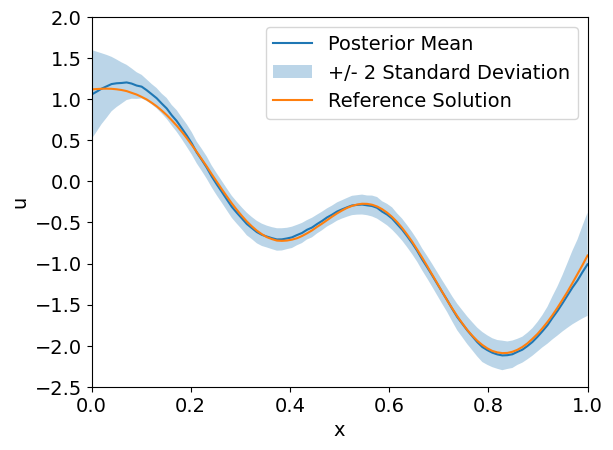

In [84]:
# Solution based on Inverse Modell and GMM Prior
xxx=onp.linspace(0,1,100)
plt.plot(xxx,onp.mean(out_u,axis=0),label='Posterior Mean')
plt.fill_between(xxx,(onp.mean(out_u,axis=0)-2*onp.std(out_u,axis=0)),(onp.mean(out_u,axis=0)+2*onp.std(out_u,axis=0)),alpha=0.3,label='+/- 2 Standard Deviation')
plt.xlabel('x')
plt.ylabel('u')

plt.plot(xxx,u_test[0,:],label='Reference Solution')
plt.legend()
plt.axis([0,1,-2.5,2.00])